In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns

In [2]:
country_data_path = '../Data/country_data'
macro_data_path = '../Data/macro_factors'
style_data_path = '../Data/style_factors'
cluster_path = '../Outputs/country_clusters'

## Load Data

### Read country sovereign bond index data

In [218]:
ticker_all = pd.read_csv(os.path.join(country_data_path, 'ice_bofa_sovereign_indices_summary.csv'), skipinitialspace=True)

In [219]:
ticker = ticker_all.loc[(ticker_all['Number of Issues'] > 5) & (ticker_all['Sum of Market Value (mm, USD)'] > 10000), :].copy()

In [220]:
ticker['Country'] = ticker['Full Index Name'].apply(lambda x:' '.join(x.split()[4:-2]))

In [221]:
ticker['Index Full Name'] = ticker['Index BBG Ticker'] + ' Index'

In [222]:
ticker[['Index Full Name', 'Country']].head()

,Index Full Name,Country
0,GDID Index,Indonesia
1,GDTR Index,Turkey
2,GDMX Index,Mexico
3,GDEG Index,Egypt
4,GDPH Index,Philippines


In [223]:
ticker['Country'].unique()

array(['Indonesia', 'Turkey', 'Mexico', 'Egypt', 'Philippines', 'Bahrain',
       'Brazil', 'Colombia', 'Dominican Republic', 'Panama', 'Qatar',
       'South Africa', 'China', 'Israel', 'Ghana', 'Peru', 'Russia',
       'Chile', 'Ukraine', 'Nigeria', 'Uruguay', 'Romania', 'Argentina'],
      dtype=object)

In [224]:
ticker_dict = pd.Series(data=ticker['Country'].values, index=ticker['Index Full Name']).to_dict()

In [225]:
bnd_idx_price = pd.read_excel(os.path.join(country_data_path, 'ice_bofa_sovereign_indices_data.xlsx'), 
                            sheet_name='px_last data',
                            skiprows=3,
                            header=0)

In [226]:
bnd_idx_price.drop(index=[0, 1], inplace=True)

In [227]:
bnd_idx_price.rename(columns={"Unnamed: 0":"Date"}, inplace=True)

In [228]:
bnd_idx_price.set_index('Date', inplace=True)

In [229]:
bnd_idx_price = bnd_idx_price.astype('float')

In [230]:
bnd_idx_price_monthly = bnd_idx_price.resample('M').last()

In [231]:
bnd_idx_price_monthly.replace(0, np.nan, inplace=True)

### Read Macro Factors Data

In [232]:
credit = pd.read_csv(os.path.join(macro_data_path, 'LF98TRUU_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['credit'])
currency = pd.read_csv(os.path.join(macro_data_path, 'MXEF0CX0_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['currency'])
equity = pd.read_csv(os.path.join(macro_data_path, 'WHANWIHD_Index.csv'), header=None, parse_dates=[0], index_col=0, names=['equity'])

In [233]:
rates = pd.read_csv(os.path.join(macro_data_path, 'JPM_GBIEM.csv'), skiprows=7, header=None, index_col=0, names=['rates_last', 'rates_mid'])
rates.index = pd.to_datetime(rates.index)
rates = rates.sort_index()
rates = rates[['rates_last']]
rates.columns = ['rates']

In [234]:
macro_factors = credit.join(currency, how='inner').join(equity, how='inner').join(rates, how='inner')

In [235]:
macro_factors_monthly = macro_factors.resample('M').last()

In [236]:
macro_factors_monthly = macro_factors_monthly.astype('float')

### Read 3-Months LIBOR data

In [237]:
libor = pd.read_csv('../Data/others/USD3MTD156N.csv', index_col=0)
libor.columns = ['3M_libor']
libor['3M_libor'] = libor['3M_libor'].replace(['.'], np.nan)
libor.fillna(method='ffill')
libor = libor.apply(pd.to_numeric)
libor.index = pd.to_datetime(libor.index)

libor_monthly = libor.resample('M').first() / 1200 # convert annual data in % to a monthly return
libor_monthly = libor_monthly.shift(1).dropna() # using first data of the month and shift by a period, to match bond index return's date convention - end of month date represents return earned over that month

## Regression

In [238]:
bnd_index_ret = np.log(bnd_idx_price_monthly).diff()

In [239]:
bnd_index_ret.describe()

,GDAM Index,GDAO Index,GDAR Index,GDAW Index,GDAZ Index,GDBB Index,GDBG Index,GDBH Index,GDBO Index,GDBR Index,...,GDTH Index,GDTN Index,GDTR Index,GDTT Index,GDUA Index,GDUY Index,GDVE Index,GDVN Index,GDZA Index,GDZM Index
count,81.000000,101.000000,29.000000,99.000000,82.000000,168.000000,252.000000,211.000000,247.000000,252.000000,...,252.000000,225.000000,252.000000,193.000000,250.000000,252.000000,252.000000,193.000000,252.000000,99.000000
mean,0.006047,0.006631,-0.030350,0.004066,0.005400,0.003300,0.004364,0.000498,-0.028352,0.008063,...,0.002174,0.002953,0.007207,0.005278,0.009189,0.007198,0.005348,0.005765,0.006130,-0.000636
std,0.025372,0.105290,0.099993,0.015719,0.026430,0.034696,0.019377,0.004146,0.375968,0.042023,...,0.006958,0.012721,0.036664,0.022922,0.063254,0.057038,0.068971,0.030727,0.026784,0.080635
min,-0.135726,-0.893634,-0.338934,-0.069766,-0.132276,-0.165833,-0.147381,-0.028790,-1.386294,-0.210894,...,-0.026065,-0.072523,-0.180034,-0.184918,-0.479180,-0.381083,-0.552361,-0.281614,-0.191556,-0.457734
25%,-0.000509,-0.009947,-0.046797,0.000253,-0.006614,-0.004802,0.000000,0.000000,-0.223144,-0.008954,...,0.000000,0.000000,-0.009614,-0.000784,-0.008629,-0.008027,-0.013282,-0.001286,-0.006053,-0.031190
50%,0.007061,0.007067,-0.004017,0.004497,0.006777,0.000000,0.000000,0.000000,0.000000,0.011402,...,0.000000,0.000000,0.009581,0.006011,0.009573,0.008662,0.005048,0.007093,0.007877,-0.000797
75%,0.014938,0.024001,0.026629,0.007867,0.020004,0.012359,0.010756,0.000000,0.108293,0.025192,...,0.000511,0.006020,0.025770,0.014888,0.030000,0.031095,0.035912,0.017246,0.019398,0.028655
max,0.076157,0.337432,0.129239,0.071567,0.055869,0.170942,0.068749,0.022393,1.860752,0.233548,...,0.035111,0.062714,0.132061,0.084104,0.326299,0.297292,0.223687,0.099489,0.100748,0.327798


In [240]:
bnd_index_ret.replace(0, np.nan, inplace=True)

In [241]:
bnd_index_excess_ret = bnd_index_ret.subtract(libor_monthly['3M_libor'], axis=0).dropna(axis=0, how='all')

In [242]:
macro_factors_ret = np.log(macro_factors_monthly).diff().dropna()

In [243]:
macro_factors_ret.describe()

,credit,currency,equity,rates
count,191.000000,191.000000,191.000000,191.000000
mean,0.005827,0.002256,0.006560,0.003693
std,0.027960,0.019484,0.040996,0.012621
min,-0.173244,-0.078636,-0.171625,-0.039949
25%,-0.003483,-0.006882,-0.012876,-0.003229
50%,0.007352,0.003989,0.013603,0.005135
75%,0.016999,0.013584,0.030295,0.010941
max,0.114263,0.050544,0.114004,0.066541


In [244]:
results_df = pd.DataFrame()
results_dict = {} 

cols = ['const'] + macro_factors_ret.columns.tolist()
beta_cols = [x + '_beta' for x in cols]
tval_cols = [x + '_tval' for x in cols]

for bnd_index in ticker_dict:
    
    country = ticker_dict[bnd_index]
    temp = bnd_index_excess_ret[bnd_index].dropna().to_frame().join(macro_factors_ret, how='inner')
    
    if temp.shape[0] > 30:

        y = temp.iloc[:, 0]
        X = temp.iloc[:, 1:]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()

        betas = results.params
        tvalues = results.tvalues
        rsq_adj = results.rsquared_adj
        f_pvalue = results.f_pvalue
        start_date = y.index.min().strftime('%Y%m')
        temp_results_df = pd.DataFrame(data=np.r_[betas, tvalues, rsq_adj, f_pvalue], 
                                       index=beta_cols + tval_cols + ['rsq_adj', 'f_pvalue']).T
        temp_results_df['country'] = country
        temp_results_df['start_date'] = start_date
        results_df = results_df.append(temp_results_df)
    
        results_dict[country] = results


In [245]:
results_df

,const_beta,credit_beta,currency_beta,equity_beta,rates_beta,const_tval,credit_tval,currency_tval,equity_tval,rates_tval,rsq_adj,f_pvalue,country,start_date
0,-0.004352,0.652970,0.033462,-0.034148,1.504776,-2.738879,7.333018,0.294827,-0.573248,10.144283,0.693218,1.721245e-47,Indonesia,200502
0,-0.003559,0.197976,0.023381,0.075436,1.668020,-2.348766,2.331310,0.216011,1.327876,11.790931,0.631059,4.453373e-40,Turkey,200502
0,-0.001289,0.318027,-0.007878,-0.078209,1.116598,-0.962752,4.237478,-0.082352,-1.557732,8.931000,0.507166,1.791194e-28,Mexico,200502
0,-0.000666,0.213845,-0.022028,0.038904,0.865868,-0.297798,1.706530,-0.137916,0.464094,4.147885,0.203410,1.938288e-09,Egypt,200502
0,-0.000003,0.373244,-0.099323,-0.058759,1.043488,-0.003115,6.292893,-1.313806,-1.480906,10.561005,0.613833,3.022625e-38,Philippines,200502
0,-0.000819,0.275178,0.248353,-0.108467,1.187598,-0.637565,3.820808,2.705430,-2.251306,9.898544,0.600436,7.059733e-37,Brazil,200502
0,-0.001587,0.438241,-0.018990,-0.041249,1.137120,-1.278108,6.297013,-0.214079,-0.885998,9.808160,0.633076,2.683372e-40,Colombia,200502
0,-0.002551,1.388732,-0.244148,-0.232054,0.927339,-1.000472,9.716472,-1.340196,-2.427017,3.894828,0.532776,1.312029e-30,Dominican Republic,200502
0,-0.001504,0.578964,-0.114146,-0.101863,1.139992,-1.180143,8.105372,-1.253733,-2.131713,9.580380,0.634996,1.651886e-40,Panama,200502
0,-0.000756,0.508978,-0.129209,-0.114119,0.620711,-0.715583,8.592736,-1.711400,-2.879948,6.290449,0.523604,7.870681e-30,Qatar,200502


In [246]:
results_df.describe()

,const_beta,credit_beta,currency_beta,equity_beta,rates_beta,const_tval,credit_tval,currency_tval,equity_tval,rates_tval,rsq_adj,f_pvalue
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,-0.001498,0.539321,-0.041085,-0.065230,0.965165,-0.771660,5.468494,-0.446707,-1.274028,7.232562,0.509056,1.143701e-07
std,0.001841,0.441283,0.146447,0.065374,0.421128,1.078005,2.812717,1.362756,1.135048,3.127886,0.144666,5.110225e-07
min,-0.004762,0.042397,-0.274502,-0.232054,0.361368,-2.738879,1.110210,-3.662358,-2.879948,1.062770,0.203410,1.721245e-47
25%,-0.003340,0.254133,-0.133532,-0.094484,0.603970,-1.204634,2.900307,-1.311007,-2.161611,4.909342,0.468582,2.278102e-38
50%,-0.001054,0.443196,-0.038507,-0.067356,1.038341,-0.839167,5.666599,-0.343538,-1.519319,8.455836,0.530320,2.376339e-30
75%,-0.000197,0.607831,0.025766,-0.038700,1.179525,-0.224127,7.848400,0.235715,-0.524464,9.637325,0.631116,8.266889e-17
max,0.001565,1.656693,0.272203,0.075436,1.800138,1.460510,10.186300,2.705430,1.327876,11.790931,0.693218,2.285464e-06


## Regression Results by Cluster

In [247]:
bond_idx_clusters = pd.read_pickle(os.path.join(cluster_path, 'clusters_bond_idx_ret_full.pkl'))
bond_idx_clusters.head()

,Countries,cluster_label
0,Bulgaria,0
1,Bolivia,0
2,Ukraine,0
3,Venezuela,0
4,El Salvador,1


In [248]:
set(bond_idx_clusters['Countries']) - set(results_df['country'])

{'Bolivia',
 'Bulgaria',
 'Costa Rica',
 'El Salvador',
 'Guatemala',
 'Hungary',
 'Jamaica',
 'Lebanon',
 'Malaysia',
 'Poland',
 'South Korea',
 'Venezuela'}

In [249]:
set(results_df['country']) - set(bond_idx_clusters['Countries'])

{'Ghana', 'Romania'}

In [250]:
results_with_cluster = results_df.merge(bond_idx_clusters, left_on='country', right_on='Countries')

In [251]:
beta_reformatted = results_with_cluster.set_index('cluster_label')[beta_cols].stack().to_frame().reset_index()
beta_reformatted.columns = ['cluster', 'beta', 'value']

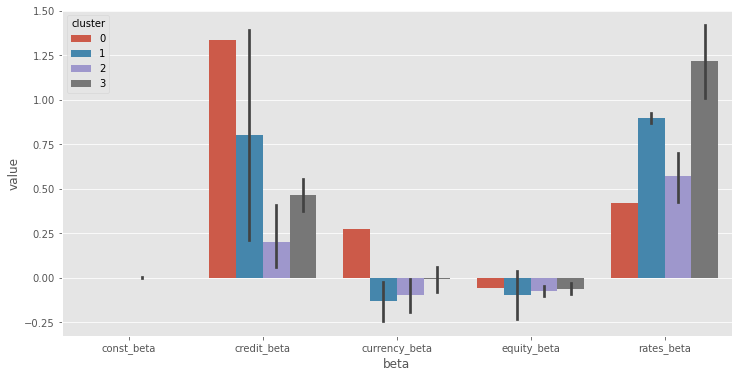

In [252]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='beta', y='value', data=beta_reformatted, hue='cluster')

In [253]:
tval_reformatted = results_with_cluster.set_index('cluster_label')[tval_cols].stack().to_frame().reset_index()
tval_reformatted.columns = ['cluster', 'tval', 'value']

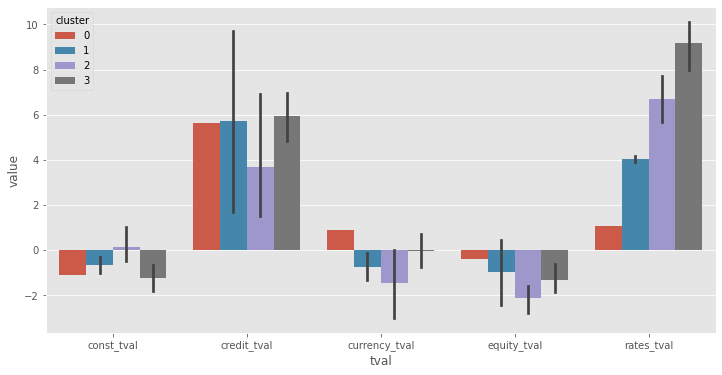

In [254]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='tval', y='value', data=tval_reformatted, hue='cluster')

In [255]:
beta_df = results_with_cluster.set_index('country')[beta_cols].T

In [256]:
tval_df = results_with_cluster.set_index('country')[tval_cols].T

In [257]:
def plot_cluster_betas(clusters_df, betas_df, cluster_n, ylim, ytitle):
    # Plot betas for each cluster
    cluster_list = list(clusters_df[clusters_df['cluster_label']==cluster_n]['Countries'])
    betas_df_tmp = betas_df[cluster_list]
    
    #no_const = betas_df_tmp.T[betas_df_tmp.T.columns[~betas_df_tmp.T.columns.isin(['const'])]]
    betas_df_tmp.T.plot(kind='bar', rot=0, figsize=(16,3))
    plt.legend(loc='upper left')
    plt.ylabel(ytitle)
    plt.ylim(-ylim,ylim)

def plot_multiple_clusters(clusters_df, betas_df, ylim, ytitle):
    all_cluster_labels = list(clusters_df['cluster_label'].unique())
    #fig, ax = plt.subplots(nrows=len(all_cluster_labels), constrained_layout=True, figsize=(12,8))
    for label_ in all_cluster_labels:
        plot_cluster_betas(clusters_df, betas_df, label_, ylim, ytitle)

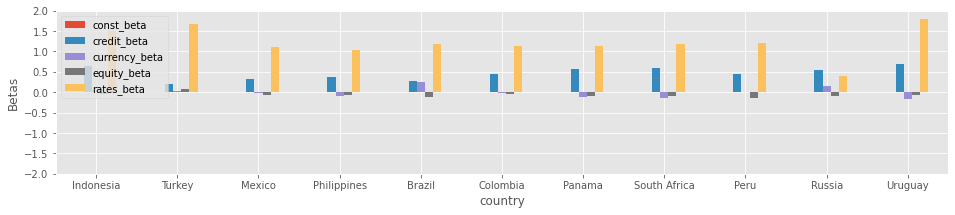

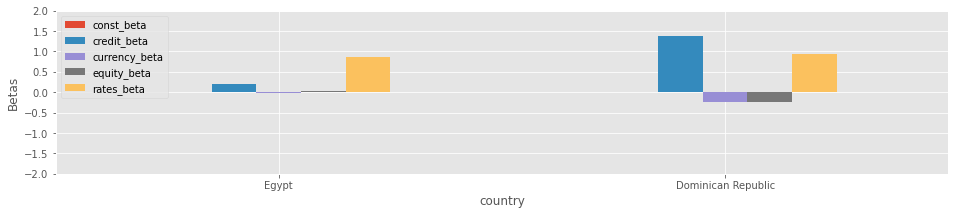

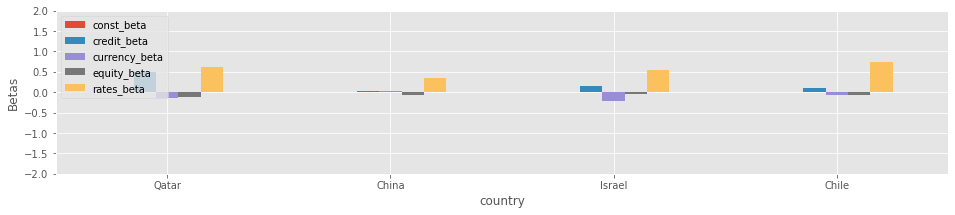

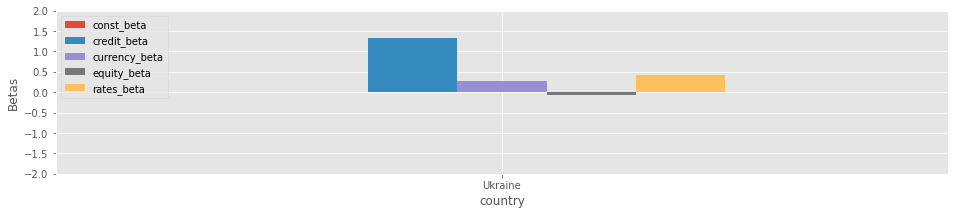

In [258]:
plot_multiple_clusters(results_with_cluster, beta_df, 2, 'Betas')

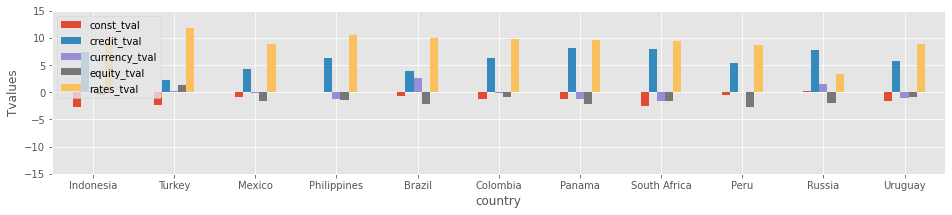

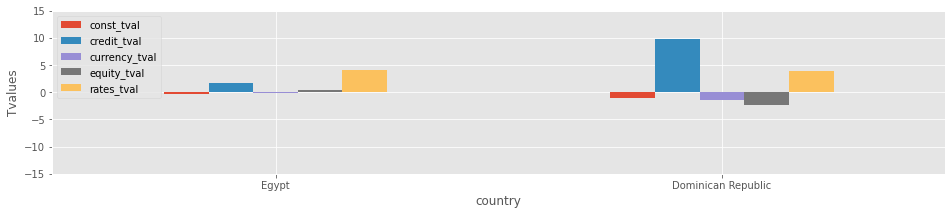

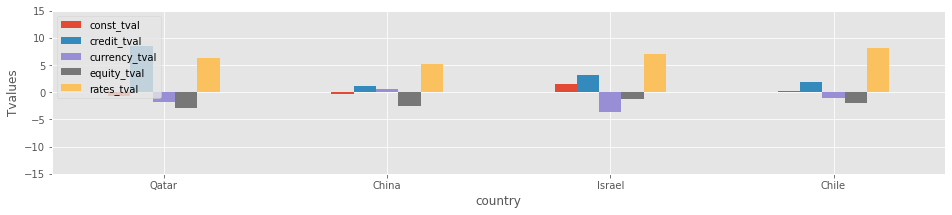

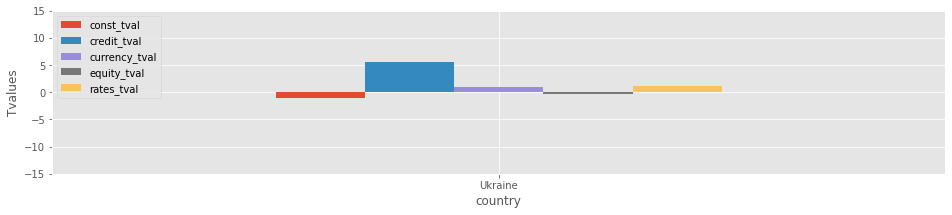

In [259]:
plot_multiple_clusters(results_with_cluster, tval_df, 15, 'Tvalues')

In [260]:
# read gov oas data for all sov bond indices
oas1 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats1.csv'), header=1, parse_dates=[0], nrows=7574, skipinitialspace=True)
oas1.dropna(axis=1, how="all", inplace=True) # delete empty column

oas2 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats2.csv'), header=1, parse_dates=[0], nrows=7552, skipinitialspace=True)
oas2.dropna(axis=1, how="all", inplace=True)

oas3 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats3.csv'), header=1, parse_dates=[0], nrows=6764, skipinitialspace=True)
oas3.dropna(axis=1, how="all", inplace=True)

oas4 = pd.read_csv(os.path.join(style_data_path, 'sov_bond_stats4.csv'), header=1, parse_dates=[0], nrows=6912, skipinitialspace=True)
oas4.dropna(axis=1, how="all", inplace=True)

In [261]:
oas = oas1[oas1['Date'] > "20050101"].merge(oas2, on='Date').merge(oas3, on='Date').merge(oas4, on='Date')

In [262]:
oas_monthly = oas.set_index('Date').resample('M').last()

In [263]:
oas_monthly.columns = oas_monthly.columns + ' Index'

In [264]:
oas_monthly_selected = oas_monthly[ticker_dict]

In [265]:
oas_monthly_selected.isna().sum().sort_values(ascending=False).head(60)

GDRO Index    85
GDCN Index    61
GDNG Index    45
GDGH Index    33
GDBH Index    29
GDAR Index    19
GDUY Index     0
GDUA Index     0
GDCL Index     0
GDRU Index     0
GDPE Index     0
GDIL Index     0
GDID Index     0
GDTR Index     0
GDQA Index     0
GDPA Index     0
GDDO Index     0
GDCO Index     0
GDBR Index     0
GDPH Index     0
GDEG Index     0
GDMX Index     0
GDZA Index     0
dtype: int64